# Reproducing geothermal ML

We are going to try to reproduce a paper on machine learning in a geothermal setting:

> Tut Haklidir, F.S., & Haklidir, M. (2019). Prediction of Reservoir Temperatures Using Hydrogeochemical Data, Western Anatolia Geothermal Systems (Turkey): A Machine Learning Approach. _Natural Resources Research_, **29**, 2333-2346. [DOI:10.1007/s11053-019-09596-0](https://link.springer.com/article/10.1007%2Fs11053-019-09596-0)

I first heard of this work at the 2020 World Geothermal Congress (which was in 2021) during this talk: https://www.youtube.com/watch?v=-Y0fb23FDzI. The talk frames the task as a classification task, predicting classes of temperature (high, medium, low). But it seems more sensible to cast this as a regression, and that's what the paper does. As far as I can tell, the two papers use the same dataset (but it's hard to be certain).

Plan:

- Load the data.
- Try to reproduce the figures in the journal article.
- Try to reproduce the results in the conference paper.

## Load and clean the data

I extracted the data from the images of the published tables (see link, above) using this tool: https://www.extracttable.com/.

First we'll load Table 1, which is the training data. I will add two columns:

- **Temperature source** – if **calculated** using a geothermometry method on geothermal spring data, or **measured** in a well. This is a red flag: are the authors trying to predict a value that was empirically computed from the of the features? Spoiler alert: yes.
- **Dataset** — **Training** or **Validation** so we know how to split the data later.

In [24]:
import pandas as pd

# Load Table 1 in two parts.
df0 = pd.read_csv("7-Table1-1.png.csv")
df1 = pd.read_csv("8-Table1-1.png.csv")
df = pd.concat([df0, df1]).reset_index(drop=True)

# Add extra information, e.g. in footnote, as features.
col = 'Temperature source'
df[col] = 'Unknown'
df.loc[df['Sample name']=='Derman', col] = 'Calculated'  # Missing.
df.loc[df['Reservoir temperature (°C)'].str.contains('a'), col] = 'Calculated'
df.loc[df['Reservoir temperature (°C)'].str.contains('b'), col] = 'Measured'
df['Dataset'] = 'Training'

# Remove footnote tags.
df['Reservoir temperature (°C)'] = (df['Reservoir temperature (°C)']
                                    .str.replace("a", "")
                                    .str.replace("b", "")
                                    .astype(float)
                                   )
df['EC (microS/cm)'] = (df['EC (microS/cm)']
                        .astype(str)
                        .str.replace(",", "")
                        .astype(float)
                       )
df.tail(10)

,Sample label,Sample name,Location,Source type,Reservoir temperature (°C),pH,EC (microS/cm),K (mg/l),Na (mg/l),Boron (mg/l),SiO2 (mg/l),Cl (mg/l),Temperature source,Dataset
56,56,KD21,Denizli,Well,205.0,8.1,4490.0,108,1149,14.0,263,85,Measured,Training
57,57,R3,Denizli,Well,190.0,8.1,4640.0,78,1229,15.0,219,121,Measured,Training
58,58,KD23B,Denizli,Well,245.0,7.2,5440.0,179,1415,25.0,434,118,Measured,Training
59,59,KD23D,Denizli,Well,238.0,7.1,5250.0,175,1341,25.0,431,109,Measured,Training
60,60,KD18A,Denizli,Well,215.0,7.0,4920.0,154,1254,24.0,351,101,Measured,Training
61,61,KD2A,Denizli,Well,237.0,7.4,4990.0,159,1239,24.0,450,103,Measured,Training
62,62,KD9A,Denizli,Well,225.0,7.0,4910.0,154,1269,26.0,381,101,Measured,Training
63,64,R1A,Denizli,Well,231.0,7.6,4360.0,118,1099,20.0,290,89,Measured,Training
64,65,R1,Denizli,Well,220.0,7.6,4990.0,153,1318,23.0,405,102,Measured,Training
65,66,R3A,Denizli,Well,243.0,7.2,5330.0,182,1417,29.0,455,113,Measured,Training


Now Tables 2 and 3 which contain the validation data.

In [25]:
# Load validation data from Table 2 and
# fix digitization problems.
df3 = pd.read_csv("8-Table2-1.png.csv")
df3.columns = df3.columns.str.replace(" 1", "l")
df3.columns = df3.columns.str.replace(" cm", "cm")
df3 = df3[df3['Sample name'].notna()]  # Got some extra rows.
df3['Sample label'] = range(67, 84)

# Load validation temperatures from Table 3 and
# insert values into Table 2.
df4 = pd.read_csv("9-Table3-1.png.csv")
df3['Reservoir temperature (°C)'] = df4['Reservoir temperature (°C)'].values
df3['Source type'] = df4['Source type'].values
df3.loc[:, col] = 'Measured'  # Missing but implied in Table 5 caption.
df3['Dataset'] = 'Validation'

df = pd.concat([df, df3]).reset_index(drop=True)

df.tail()

,Sample label,Sample name,Location,Source type,Reservoir temperature (°C),pH,EC (microS/cm),K (mg/l),Na (mg/l),Boron (mg/l),SiO2 (mg/l),Cl (mg/l),Temperature source,Dataset
78,79,KD14,Denizli,Well,208.0,8.9,4890.0,129.0,1257.0,20.0,292.0,100.0,Measured,Validation
79,80,KD22,Denizli,Well,201.0,8.3,4750.0,126.0,1225.0,17.0,258.0,92.0,Measured,Validation
80,81,R6,Denizli,Well,207.0,8.4,4590.0,117.0,1258.0,21.0,249.0,94.0,Measured,Validation
81,82,R5A,Denizli,Well,230.0,7.5,4680.0,131.0,1232.0,22.0,650.0,95.0,Measured,Validation
82,83,K5,Denizli,Thermal spring,190.0,7.5,4500.0,74.0,1126.0,12.0,191.0,90.0,Measured,Validation


**Note that there are two samples labeled 35 and no sample 63. This is how the dataset was published.**

## Question about the temperatures

I believe the adiabatic (i.e. with steam loss, for open systems) silica geothemometry equation for high-temperature systems (over 150 deg C) is:

$$ T = \frac{1522}{5.75 - log(S)} - 273.15  $$

where $S$ is in mg/kg. There are adjustments to the parameters in this equation for low temperature systems.

The problem here is that if T was calculated from SiO<sub>2</sub> then all we can achieve with machine learning is the discovery of that linear relationship. So I'm inclined to throw out the data from thermal springs — unfortunately it's a lot of data.

In [33]:
df.loc[df['Source type']=='Thermal spring'].count()['Sample label']

60

So only 23 samples out of 83 are from wells.

Let's compute this temperature and see if we can figure out where the numbers in the temperature column came from.

In [34]:
import numpy as np

def geotemp(S: float) -> float:
    """
    Fournier 1977 equation for temperature from silica,
    without steam loss.
    """
    return 1522 / (5.75 - np.log10(S)) - 273.15

In [35]:
# Add geothermometry as feature.
df['Geothermometry'] = df['SiO2 (mg/l)'].map(geotemp)

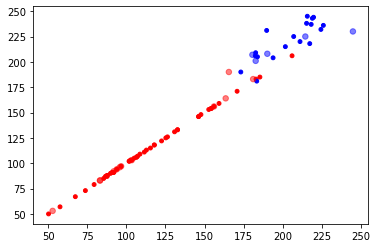

In [98]:
import matplotlib.pyplot as plt

is_spring = lambda x: x=='Thermal spring'
plt.scatter(df['Geothermometry'],
            df['Reservoir temperature (°C)'],
            c=is_spring(df['Source type']), cmap='bwr',
            s=30*((1+(df['Dataset']!="Training"))/2),  # Validation points are larger.
            alpha=((1+(df['Dataset']=="Training"))/2)  # Validation points are semi-transp.
           )

Wow.

So to obtain the reservoir temperature, which is the target of their machine learning task, the authors applied this equation to the silica concentration even though:

1. They are trying to predict temperature from the geochemistry.
1. The equation is not appropriate for temperatures below about 150 degC. (This doesn't really matter though, becase of the first point.)

This undermines the entire piece of work, limiting it to the 23 samples from wells that have independent measures of temperature.

## Write out new data table

Let's write the new dataset out, for posterity.

In [37]:
df.to_csv('haklidir-and-haklidir-2019__cleaned.csv', index=False)

## Create `X` and `y` and split the data

The authors state in Figure 4 they were using **Temperature** as input, as well as output. But they can't have been doing that because it would lead to perfect predictions. So I'm not sure what that feature is and assume it was a mistake to indicate it as an input.

They also state that they did use SiO<sub>2</sub>, even though it was used to compute the target. I've checked the models with and without this feature, and whether I use it or not, I cannot reproduce their results, so it's hard to say. I hope they did not use it, but I suspect they did (indeed, the errors I get are more in line with theirs if I do use it).

In [116]:
features = ['pH', 'EC (microS/cm)', 'K (mg/l)', 'Na (mg/l)', 'Boron (mg/l)', 'SiO2 (mg/l)', 'Cl (mg/l)']
target = 'Reservoir temperature (°C)'

# Conditions.
train = df['Dataset']=='Training'
val = df['Dataset']=='Validation'
well = df['Source type']=='Well'

X_train = df.loc[train & well, features]
y_train = df.loc[train & well, target]
X_val = df.loc[val & well, features]
y_val = df.loc[val & well, target]

In [117]:
X_train.shape, X_val.shape

((18, 7), (5, 7))

## Standardize the data

The authors do not say if they did this or not. Since the scales of the inputs vary so widely, and since we're using models like SVM and a neural network, it's an important step. For now we'll just scale the inputs, but the neural net will probably perform better with scaled output as well.

In [118]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)

### Train and predict: Linear regression

The authors don't say if they were using regularization or not, but we want the best result possible so we'll use it. I tuned it manually.

In [119]:
from sklearn.linear_model import LinearRegression, Ridge

model = Ridge(alpha=10)
model.fit(X_train, y_train)
y_pred = model.predict(X_val)
y_hat = model.predict(X_train)

In [120]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

rmse = np.sqrt(mean_squared_error(y_val, y_pred))
mae = mean_absolute_error(y_val, y_pred)

print(f'RMSE for linear regression: {rmse:.1f} deg C')
print(f'MAE for linear regression: {mae:.1f} deg C')

RMSE for linear regression: 5.2 deg C
MAE for linear regression: 4.3 deg C


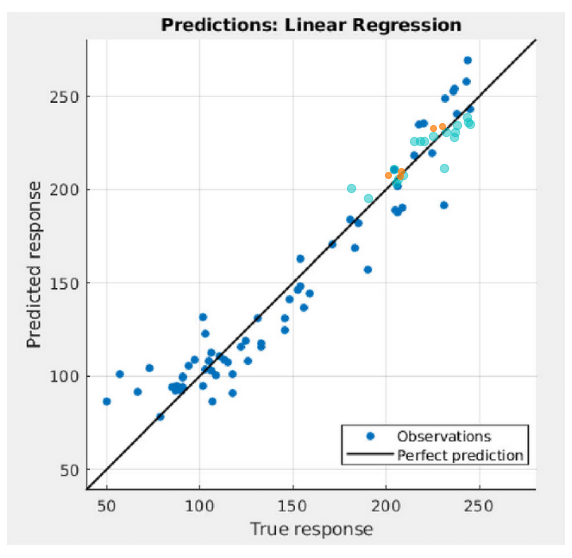

In [121]:
import matplotlib.pyplot as plt

im = plt.imread('Fig7a.png')
extent = [-3.8, 296, 9, 295]

plt.figure(figsize=(10, 10))
plt.imshow(im, origin='upper', extent=extent)
plt.scatter(y_train, y_hat, alpha=0.5, s=70, c='c')
plt.scatter(y_val, y_pred, c='C1', alpha=0.75)
plt.axis('equal')
plt.axis('off')
plt.show()

### Train and predict: linear SVM

Again the authors don't say if they applied regularization or not. We'll use it (it's on by default).

In [122]:
from sklearn.svm import SVR

svm = SVR(kernel='linear', C=1)
svm.fit(X_train, y_train)
y_pred = svm.predict(X_val)
y_hat = svm.predict(X_train)

In [123]:
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
mae = mean_absolute_error(y_val, y_pred)

print(f'RMSE for linear SVM: {rmse:.1f} deg C')
print(f'MAE for linear SVM: {mae:.1f} deg C')

RMSE for linear SVM: 4.6 deg C
MAE for linear SVM: 3.8 deg C


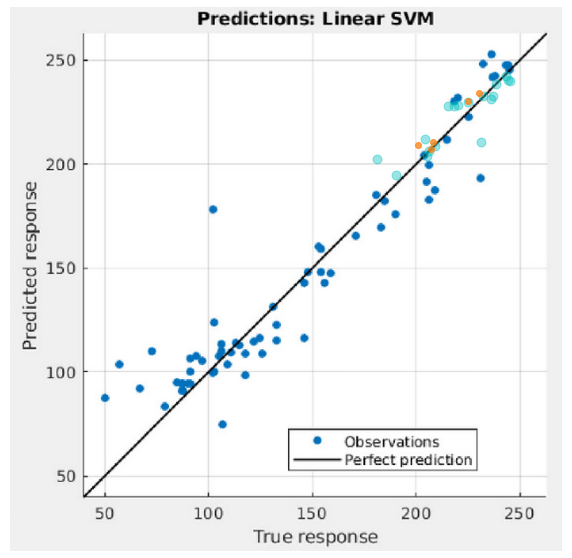

In [124]:
im = plt.imread('Fig7b.png')
extent = [5, 270, 14, 275]

plt.figure(figsize=(10, 10))
plt.imshow(im, origin='upper', extent=extent)
plt.scatter(y_train, y_hat, alpha=0.4, s=80, c='c')
plt.scatter(y_val, y_pred, c='C1', alpha=0.75)
plt.axis('equal')
plt.axis('off')
plt.show()

### Non-linear SVM

I was curious how this would do in comparison.

Let's tune the regularization parameter `C` a bit to get a reasonable fit without overtraining:

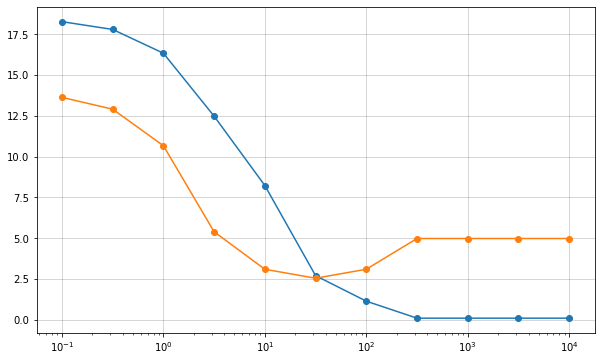

In [125]:
Cs = np.logspace(-1, 4, 11)
trains, vals = [], []

for C in Cs:
    svm = SVR(C=C)
    svm.fit(X_train, y_train)
    y_pred = svm.predict(X_val)
    y_hat = svm.predict(X_train)

    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    rmse_train = np.sqrt(mean_squared_error(y_hat, y_train))

    trains.append(rmse_train)
    vals.append(rmse)

plt.figure(figsize=(10, 6))
plt.plot(Cs, trains, 'o-')
plt.plot(Cs, vals, 'o-')
plt.xscale('log')
plt.grid(c='k', alpha=0.2)

In [126]:
Cbest = Cs[np.argmin(vals)]
Cbest

31.622776601683793

In [127]:
svm = SVR(C=Cbest)
svm.fit(X_train, y_train)
y_pred = svm.predict(X_val)
y_hat = svm.predict(X_train)

rmse = np.sqrt(mean_squared_error(y_val, y_pred))
mae = mean_absolute_error(y_val, y_pred)

print(f'RMSE for non-linear SVM: {rmse:.1f} deg C')
print(f'MAE for non-linear SVM: {mae:.1f} deg C')

RMSE for non-linear SVM: 2.5 deg C
MAE for non-linear SVM: 2.1 deg C


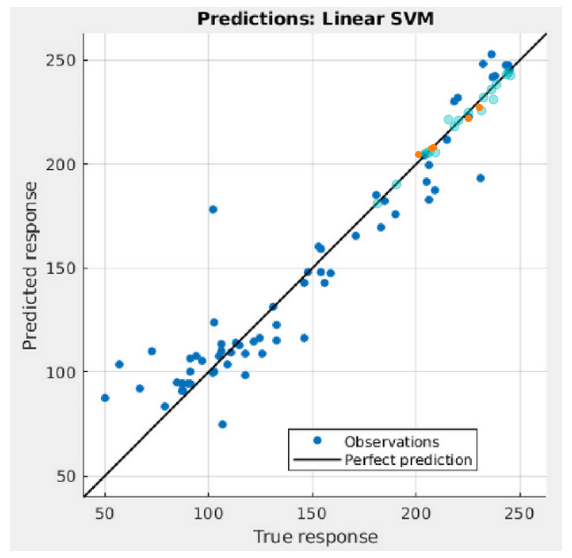

In [128]:
im = plt.imread('Fig7b.png')
extent = [5, 270, 14, 275]

plt.figure(figsize=(10, 10))
plt.imshow(im, origin='upper', extent=extent)
plt.scatter(y_train, y_hat, alpha=0.4, s=80, c='c')
plt.scatter(y_val, y_pred, c='C1')
plt.axis('equal')
plt.axis('off')
plt.show()

Clearly much better (and the fit to the training data is, not surprisingly, almost perfect).

### Train and predict: Neural network

First let's scale the output:

In [129]:
yscaler = StandardScaler()
yscaler.fit(y_train.values.reshape(-1, 1))
y_train_ = yscaler.transform(y_train.values.reshape(-1, 1)).squeeze()
y_val_ = yscaler.transform(y_val.values.reshape(-1, 1)).squeeze()

The authors do not say (in the talk, or in the paper) what the architecture of their network is, although the figure implies that it has 2 hidden layers (i.e. not including input or output).

They also don't mention the activation function, optimization strategy, regularization applied... or basically give any details at all.

In [130]:
from sklearn.neural_network import MLPRegressor

net = MLPRegressor(hidden_layer_sizes=(5, 5),
                   max_iter=500,
                   random_state=42,
                  )
net.fit(X_train, y_train_)
y_pred_ = net.predict(X_val)
y_hat_ = net.predict(X_train)

y_pred = yscaler.inverse_transform(y_pred_)
y_hat = yscaler.inverse_transform(y_hat_)

rmse = np.sqrt(mean_squared_error(y_val, y_pred))
mae = mean_absolute_error(y_val, y_pred)

print(f'RMSE for neural net: {rmse:.1f} deg C')
print(f'MAE for neural net: {mae:.1f} deg C')

RMSE for neural net: 13.0 deg C
MAE for neural net: 9.2 deg C


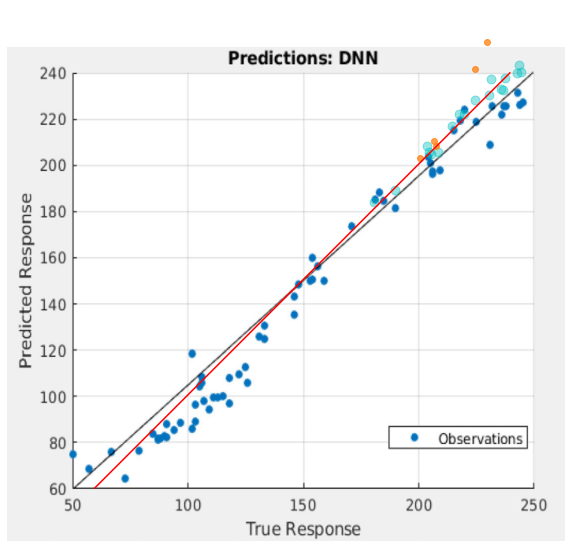

In [131]:
im = plt.imread('Fig7c.png')
extent = [22, 264, 37, 251]

plt.figure(figsize=(10, 10))
plt.imshow(im, origin='upper', extent=extent)
plt.scatter(y_train, y_hat, alpha=0.4, s=80, c='c')
plt.scatter(y_val, y_pred, c='C1', alpha=0.75)
plt.plot([60, 240], [60, 240], c='r')
plt.axis('equal')
plt.axis('off')
plt.show()

Note that the $x = y$ line in the published plot is incorrect so I plotted a new one (red).

Safe to say that our results do not agree.